In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, HashingTF, IDF, Tokenizer, StopWordsRemover, RegexTokenizer, NGram, Normalizer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F  # Menggunakan alias untuk menghindari konflik
import plotly.express as px
import plotly.graph_objects as go
import warnings
from pyspark.sql.window import Window
from pyspark.sql.functions import col,isnan, when, count, mean,  split, explode, isnull, trim, desc, concat_ws, lower, regexp_replace, repeat, avg, abs, udf
from pyspark.sql import DataFrame
from typing import Optional, List
from pyspark.ml.linalg import Vectors, DenseVector, SparseVector, VectorUDT
warnings.filterwarnings('ignore')
print("🚀 IMPORT COMPLETED!")

🚀 IMPORT COMPLETED!


In [2]:
# Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("Amazon Recommender System") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

# Set log level untuk mengurangi noise
spark.sparkContext.setLogLevel("WARN")

print("🚀 Spark Session berhasil dibuat!")
print(f"Spark Version: {spark.version}")
print(f"Available Cores: {spark.sparkContext.defaultParallelism}")

🚀 Spark Session berhasil dibuat!
Spark Version: 3.5.1
Available Cores: 2


In [3]:
# Membaca data CSV dengan error handling yang lebih baik
try:
    df = spark.read.option("header", "true") \
        .option("inferSchema", "true") \
        .option("multiline", "true") \
        .option("escape", '"') \
        .option("spark.sql.shuffle.partitions", 20) \
        .option("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .option("quote", '"') \
        .csv("amazon.csv")


    print(f"✅ Data berhasil dimuat: {df.count()} baris")
except Exception as e:
    print(f"❌ Error saat membaca file: {e}")

✅ Data berhasil dimuat: 1465 baris


📊 **INFORMASI DASAR DATASET**

In [4]:
print("\n📊 INFORMASI DASAR DATASET")
print("=" * 50)
print(f"Jumlah Baris: {df.count()}")
print(f"Jumlah Kolom: {len(df.columns)}")

# Cek kolom yang tersedia
print("\n📋 KOLOM YANG TERSEDIA:")
for i, column in enumerate(df.columns, 1):
    print(f"{i:2d}. {column}")

# Menampilkan schema dengan penanganan yang lebih baik
print("\n🔍 SCHEMA DATASET")
print("=" * 50)
df.printSchema()

# Tampilkan sample data
print("\n📋 SAMPLE DATA (3 baris pertama)")
print("=" * 50)
df.show(3, truncate=True)


📊 INFORMASI DASAR DATASET
Jumlah Baris: 1465
Jumlah Kolom: 16

📋 KOLOM YANG TERSEDIA:
 1. product_id
 2. product_name
 3. category
 4. discounted_price
 5. actual_price
 6. discount_percentage
 7. rating
 8. rating_count
 9. about_product
10. user_id
11. user_name
12. review_id
13. review_title
14. review_content
15. img_link
16. product_link

🔍 SCHEMA DATASET
root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- discounted_price: string (nullable = true)
 |-- actual_price: string (nullable = true)
 |-- discount_percentage: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- rating_count: string (nullable = true)
 |-- about_product: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_content: string (nullable = true)
 |-- img_link: string (n

📊 **CLEANING DATASET**

Missing Value

In [5]:
def check_missing_values(df: DataFrame,
                        columns: Optional[List[str]] = None,) -> Optional[DataFrame]:

    # Tentukan kolom yang akan dicek
    if columns is None:
        columns_to_check = df.columns
    else:
        # Validasi kolom yang diminta ada di DataFrame
        invalid_cols = [col for col in columns if col not in df.columns]
        if invalid_cols:
            raise ValueError(f"Kolom tidak ditemukan: {invalid_cols}")
        columns_to_check = columns

    # expression untuk menghitung missing values
    missing_expressions = [count(when(isnan(col(c)) | isnull(col(c)), c)).alias(c) for c in columns_to_check]

    # Hitung missing values
    result_df = df.select(missing_expressions).show()

    return result_df

In [6]:
# Cek null value untuk setiap kolom
check_missing_values(df)

+----------+------------+--------+----------------+------------+-------------------+------+------------+-------------+-------+---------+---------+------------+--------------+--------+------------+
|product_id|product_name|category|discounted_price|actual_price|discount_percentage|rating|rating_count|about_product|user_id|user_name|review_id|review_title|review_content|img_link|product_link|
+----------+------------+--------+----------------+------------+-------------------+------+------------+-------------+-------+---------+---------+------------+--------------+--------+------------+
|         0|           0|       0|               0|           0|                  0|     0|           2|            0|      0|        0|        0|           0|             0|       0|           0|
+----------+------------+--------+----------------+------------+-------------------+------+------------+-------------+-------+---------+---------+------------+--------------+--------+------------+



In [7]:
# Kita ganti null values di rating count dengan nilai rata rata rating_count

# Hitung mean rating_count
mean_value = df.select(mean(col("rating_count"))).collect()[0][0]

# Ganti nilai null dengan mean
df = df.fillna({"rating_count": mean_value})

In [8]:
# Cek lagi null value untuk setiap kolom
check_missing_values(df)

+----------+------------+--------+----------------+------------+-------------------+------+------------+-------------+-------+---------+---------+------------+--------------+--------+------------+
|product_id|product_name|category|discounted_price|actual_price|discount_percentage|rating|rating_count|about_product|user_id|user_name|review_id|review_title|review_content|img_link|product_link|
+----------+------------+--------+----------------+------------+-------------------+------+------------+-------------+-------+---------+---------+------------+--------------+--------+------------+
|         0|           0|       0|               0|           0|                  0|     0|           0|            0|      0|        0|        0|           0|             0|       0|           0|
+----------+------------+--------+----------------+------------+-------------------+------+------------+-------------+-------+---------+---------+------------+--------------+--------+------------+



DUPLICATE DATA

In [9]:
# 2. Deteksi dan tangani duplikat
def analisis_duplikat(df, key_columns=None):
    if key_columns is None:
        key_columns = ["product_id"]

    # Hitung jumlah kemunculan untuk setiap nilai unik pada key_columns
    window = Window.partitionBy(key_columns)
    df_with_count = df.withColumn("duplicate_count", F.count("*").over(window))

    # Identifikasi duplikat (duplicate_count > 1)
    duplicate_counts = df_with_count.filter(F.col("duplicate_count") > 1) \
                                   .select(*key_columns, "duplicate_count") \
                                   .distinct()

    num_unique = df.select(*key_columns).distinct().count()
    num_duplicates = df.count() - num_unique

    print(f"\nANALISIS DUPLIKAT BERDASARKAN {', '.join(key_columns)}:")
    print(f"Total baris: {df.count()}")
    print(f"Baris unik: {num_unique}")
    print(f"Baris duplikat: {num_duplicates}")

    if duplicate_counts.count() > 0:
        print("\nContoh data duplikat:")
        duplicate_counts.show(3, truncate=False)
    else:
        print("Tidak ditemukan data duplikat.")

    return num_duplicates

# Hapus duplikat berdasarkan product_id
def hapus_duplikat(df, key_columns=None):
    if key_columns is None:
        key_columns = ["product_id"]

    # Drop duplikat, simpan kolom rating tertinggi
    df_no_dupes_higher_rating = df.orderBy(F.desc("rating")).dropDuplicates(key_columns)
    return df_no_dupes_higher_rating

# Analisis duplikat sebelum pembersihan
analisis_duplikat(df, ["product_id"])

# Hapus duplikat
df = hapus_duplikat(df, ["product_id"])


ANALISIS DUPLIKAT BERDASARKAN product_id:
Total baris: 1465
Baris unik: 1351
Baris duplikat: 114

Contoh data duplikat:
+----------+---------------+
|product_id|duplicate_count|
+----------+---------------+
|B002PD61Y4|2              |
|B008FWZGSG|2              |
|B00NH11KIK|2              |
+----------+---------------+
only showing top 3 rows



In [10]:
# Analisis duplikat setelah pembersihan
analisis_duplikat(df, ["product_id"])


ANALISIS DUPLIKAT BERDASARKAN product_id:
Total baris: 1351
Baris unik: 1351
Baris duplikat: 0
Tidak ditemukan data duplikat.


0

**DATA ENRICHMENT (TERUTAMA MEMBANTU VISUALISASI)**

In [11]:
# PEMBERSIHAN DATA DENGAN METODE YANG LEBIH ROBUST
print("\n🧹 PROSES PEMBERSIHAN DATA")
print("=" * 50)

# Menggunakan F.col() instead of col() untuk menghindari konflik
try:
    # Membersihkan kolom harga dengan regex yang lebih spesifik
    df_clean = df.withColumn("discounted_price_clean",
                            F.regexp_replace(F.col("discounted_price"), "[₹,]", "")) \
                 .withColumn("actual_price_clean",
                            F.regexp_replace(F.col("actual_price"), "[₹,]", "")) \
                 .withColumn("discount_percentage_clean",
                            F.regexp_replace(F.col("discount_percentage"), "%", ""))

    print("✅ Pembersihan teks berhasil")

    # Konversi ke numeric dengan error handling
    df_clean = df_clean.withColumn("discounted_price_numeric",
                                  F.col("discounted_price_clean").cast("double")) \
                       .withColumn("actual_price_numeric",
                                  F.col("actual_price_clean").cast("double")) \
                       .withColumn("discount_percentage_numeric",
                                  F.col("discount_percentage_clean").cast("double")) \
                       .withColumn("rating_numeric",
                                  F.col("rating").cast("double"))

    print("✅ Konversi numeric berhasil")
    print("Jumlah Data setelah pembersihan :", df_clean.count())

except Exception as e:
    print(f"❌ Error dalam pembersihan data: {e}")
    print("🔄 Mencoba metode alternatif...")

    # Metode alternatif jika regex gagal
    df_clean = df.select("*")
    for column in ["discounted_price", "actual_price"]:
        if column in df.columns:
            df_clean = df_clean.withColumn(f"{column}_numeric",
                                         F.regexp_replace(F.col(column), "[^0-9.]", "").cast("double"))


🧹 PROSES PEMBERSIHAN DATA
✅ Pembersihan teks berhasil
✅ Konversi numeric berhasil
Jumlah Data setelah pembersihan : 1351


In [12]:
# Cek hasil pembersihan data
print("\n🔍 CEK HASIL PEMBERSIHAN")
print("=" * 50)

# Tampilkan kolom yang berhasil dibuat
numeric_columns = [col for col in df_clean.columns if "numeric" in col]
print(f"Kolom numeric yang berhasil dibuat: {numeric_columns}")

# Statistik deskriptif untuk kolom yang berhasil
if numeric_columns:
    try:
        print("\n📊 STATISTIK DESKRIPTIF")
        df_clean.select(*numeric_columns).describe().show()
    except Exception as e:
        print(f"Error dalam statistik: {e}")


🔍 CEK HASIL PEMBERSIHAN
Kolom numeric yang berhasil dibuat: ['discounted_price_numeric', 'actual_price_numeric', 'discount_percentage_numeric', 'rating_numeric']

📊 STATISTIK DESKRIPTIF
+-------+------------------------+--------------------+---------------------------+-------------------+
|summary|discounted_price_numeric|actual_price_numeric|discount_percentage_numeric|     rating_numeric|
+-------+------------------------+--------------------+---------------------------+-------------------+
|  count|                    1351|                1351|                       1351|               1350|
|   mean|      3304.8017542561065|   5691.176624722428|          46.68541820873427|   4.09185185185186|
| stddev|       7173.975454857663|  11218.666234646322|          21.63261088913051|0.29744447796601703|
|    min|                    39.0|                39.0|                        0.0|                2.0|
|    max|                 77990.0|            139900.0|                       94.0|  

**EXPLORASI DATA (EDA)**

In [13]:
# INSIGHT DAN REKOMENDASI
print("\n💡 RINGKASAN ANALISIS")
print("=" * 50)

try:
    total_products = df.count()
    valid_price_products = df_clean.filter(F.col("discounted_price_numeric").isNotNull()).count()
    valid_rating_products = df_clean.filter(F.col("rating").isNotNull()).count()

    print(f"📊 Total produk: {total_products}")
    print(f"📊 Produk dengan harga valid: {valid_price_products}")
    print(f"📊 Produk dengan rating valid: {valid_rating_products}")

    # Statistik basic jika ada data valid
    if valid_price_products > 0:
        price_stats = df_clean.filter(F.col("discounted_price_numeric").isNotNull()) \
                             .agg(F.min("discounted_price_numeric").alias("min_price"),
                                  F.max("discounted_price_numeric").alias("max_price"),
                                  F.avg("discounted_price_numeric").alias("avg_price")) \
                             .collect()[0]

        print(f"💰 Rentang harga: ₹{price_stats['min_price']:.0f} - ₹{price_stats['max_price']:.0f}")
        print(f"💰 Rata-rata harga: ₹{price_stats['avg_price']:.0f}")

    if valid_rating_products > 0:
        rating_stats = df_clean.filter(F.col("rating_numeric").isNotNull()) \
                              .agg(F.avg("rating_numeric").alias("avg_rating")) \
                              .collect()[0]['avg_rating']

        print(f"⭐ Rata-rata rating: {rating_stats:.2f}")

except Exception as e:
    print(f"Error dalam ringkasan: {e}")


💡 RINGKASAN ANALISIS
📊 Total produk: 1351
📊 Produk dengan harga valid: 1351
📊 Produk dengan rating valid: 1351
💰 Rentang harga: ₹39 - ₹77990
💰 Rata-rata harga: ₹3305
⭐ Rata-rata rating: 4.09



🏷️ ANALISIS KATEGORI PRODUK
+-----------------------------------------------------------------------------------------------------+-----+
|category                                                                                             |count|
+-----------------------------------------------------------------------------------------------------+-----+
|Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                    |161  |
|Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                                 |68   |
|Electronics|WearableTechnology|SmartWatches                                                          |62   |
|Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                                        |60   |
|Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                         |51   |
|Electronics|HomeTheater,TV&Video|Accessories|RemoteControls                               

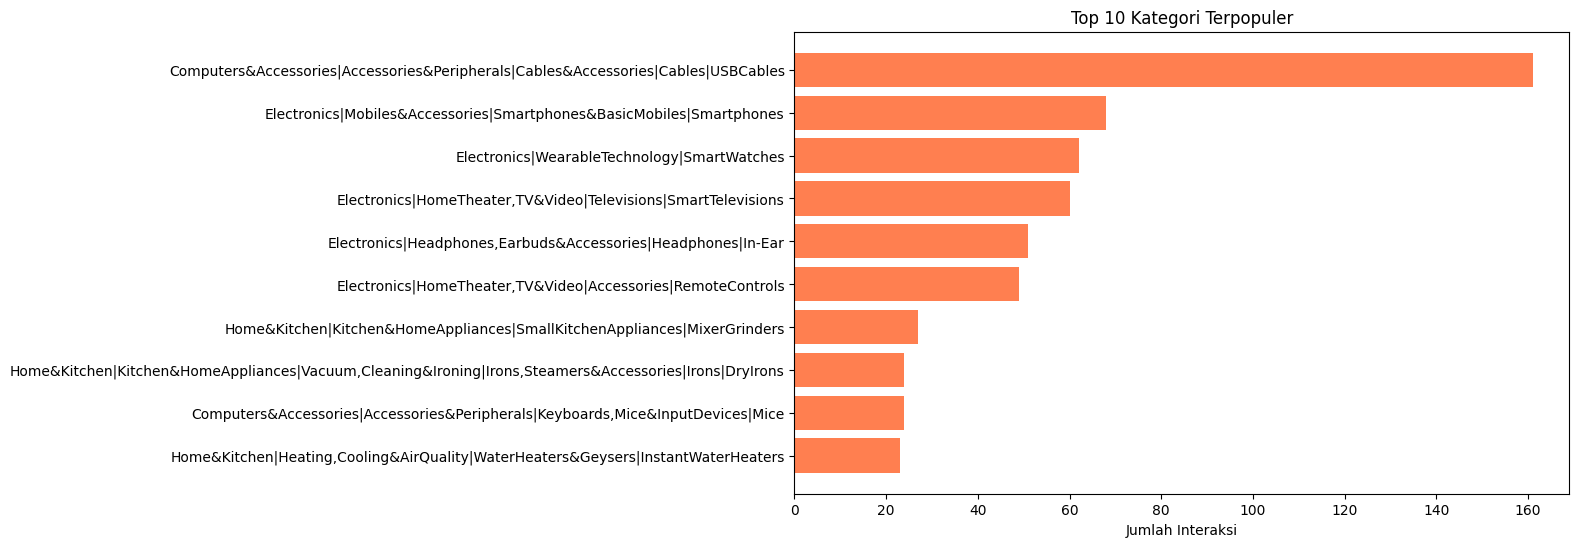

In [14]:
# TOP 10 KATEGORI
print("\n🏷️ ANALISIS KATEGORI PRODUK")
print("=" * 50)

if "category" in df.columns:
    try:
      top_category = df_clean.groupBy("category").count().orderBy(F.desc("count"))

      top_category.show(10, truncate=False)

      # Visualisasi
      top_cat_pd = top_category.limit(10).toPandas()

      plt.figure(figsize=(10,6))
      plt.barh(top_cat_pd['category'], top_cat_pd['count'], color='coral')
      plt.xlabel("Jumlah Interaksi")
      plt.title("Top 10 Kategori Terpopuler")
      plt.gca().invert_yaxis()
      plt.show()


    except Exception as e:
        print(f"Error dalam analisis kategori: {e}")

In [15]:
print("\n📊 PERSIAPAN VISUALISASI")
print("=" * 50)

try:
    # Filter data yang valid untuk visualisasi
    valid_data = df_clean.filter(F.col("discounted_price_numeric").isNotNull() &
                                F.col("rating_numeric").isNotNull())

    pdf = valid_data.toPandas()

    # VISUALISASI DENGAN PLOTLY
    print("\n🎨 MEMBUAT VISUALISASI")
    print("=" * 50)

    # Scatter plot Harga vs Rating
    if all(col in pdf.columns for col in ['discounted_price_numeric', 'rating_numeric']):
        # Filter outlier untuk visualisasi yang lebih baik
        pdf_filtered = pdf[(pdf['discounted_price_numeric'] < pdf['discounted_price_numeric'].quantile(0.95))]

        fig3 = px.scatter(pdf_filtered,
                         x='discounted_price_numeric',
                         y='rating_numeric',
                         title='💰 Hubungan Harga vs Rating',
                         labels={'discounted_price_numeric': 'Harga (₹)',
                                'rating_numeric': 'Rating'},
                         opacity=0.7)
        fig3.show()
        print("✅ Scatter plot berhasil dibuat")

except Exception as e:
    print(f"❌ Error dalam visualisasi: {e}")
    print("💡 Tip: Pastikan data memiliki nilai numeric yang valid")


📊 PERSIAPAN VISUALISASI

🎨 MEMBUAT VISUALISASI


✅ Scatter plot berhasil dibuat


**OUTLIER,**

outlier tidak dibersihkan karena Dalam Konteks ALS Collaborative Filtering:
- Rating ekstrem justru membantu model mempelajari preferensi pengguna.
- Dalam sistem rekomendasi, variasi rating penting untuk melatih model.

In [16]:
# ANALISIS LANJUTAN produk terbaik berdasarkan harga dan rating.
def analyze_top_products(df, price_col="discounted_price_numeric", rating_col="rating_numeric", limit=5):
    try:
        # Produk dengan rating tertinggi
        top_rated = df_clean.filter(F.col(rating_col).isNotNull()) \
                     .orderBy(F.desc(rating_col)) \
                     .select("product_name", price_col, rating_col) \
                     .limit(limit)

        print(f"\n🏆 TOP {limit} PRODUK RATING TERTINGGI:")
        top_rated.show(limit, truncate=False)

        # Produk termurah dengan rating bagus (≥4.0)
        best_value = df_clean.filter((F.col(rating_col) >= 4.0) &
                              (F.col(price_col).isNotNull())) \
                       .orderBy(F.asc(price_col)) \
                       .select("product_name", price_col, rating_col) \
                       .limit(limit)

        print(f"\n💎 TOP {limit} PRODUK VALUE TERBAIK (Rating ≥4.0, Harga Termurah):")
        best_value.show(limit, truncate=False)

        return top_rated, best_value

    except Exception as e:
        print(f"Error dalam analisis top products: {e}")
        return None, None

# Jalankan analisis top products
if 'discounted_price_numeric' in df_clean.columns and 'rating_numeric' in df_clean.columns:
    top_rated, best_value = analyze_top_products(df_clean)



🏆 TOP 5 PRODUK RATING TERTINGGI:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+--------------+
|product_name                                                                                                                                                                                                                                                                |discounted_price_numeric|rating_numeric|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+--------------+
|Amazon Basics Wireless Mouse | 2

**PRE-PROCESSING**

In [17]:
# Preprocessing untuk User-Item Data
# Explode user_id yang berformat comma-separated menjadi individual rows
# Data user_id dalam format string terpisah koma, perlu di-split untuk individual interactions

# Split user_id dan buat individual user-product interactions
df_interactions = df_clean.select(
    explode(split(col("user_id"), ",")).alias("user_id_clean"),
    col("product_id"),
    col("rating"),
    col("category"),
    col("product_name"),
    col("about_product")
).filter(
    # Filter out empty user IDs
    trim(col("user_id_clean")) != ""
)

df_interactions.cache()
print(f"Individual interactions: {df_interactions.count()} rows")
df_interactions.show(3)

Individual interactions: 10598 rows
+--------------------+----------+------+--------------------+--------------------+--------------------+
|       user_id_clean|product_id|rating|            category|        product_name|       about_product|
+--------------------+----------+------+--------------------+--------------------+--------------------+
|AFRB32NPLQW24ZGJT...|B088WCFPQF|   4.5|Home&Kitchen|Kitc...|Cafe JEI French P...|4 LEVEL FILTRATIO...|
|AG2PGVWTVLRVZRJCJ...|B088WCFPQF|   4.5|Home&Kitchen|Kitc...|Cafe JEI French P...|4 LEVEL FILTRATIO...|
|AGWINPX6IU25IAPSX...|B088WCFPQF|   4.5|Home&Kitchen|Kitc...|Cafe JEI French P...|4 LEVEL FILTRATIO...|
+--------------------+----------+------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [18]:
# Analisis duplikat
analisis_duplikat(df_interactions, ["user_id_clean", "product_id"])


ANALISIS DUPLIKAT BERDASARKAN user_id_clean, product_id:
Total baris: 10598
Baris unik: 10597
Baris duplikat: 1

Contoh data duplikat:
+----------------------------+----------+---------------+
|user_id_clean               |product_id|duplicate_count|
+----------------------------+----------+---------------+
|AHBZTGUKAUVUWWRIX5NAR3LFRRDQ|B075DB1F13|2              |
+----------------------------+----------+---------------+



1

In [19]:
# Hapus duplikat
df_interactions = hapus_duplikat(df_interactions, ["user_id_clean", "product_id"])

In [20]:
# Analisis duplikat
analisis_duplikat(df_interactions, ["user_id_clean", "product_id"])


ANALISIS DUPLIKAT BERDASARKAN user_id_clean, product_id:
Total baris: 10597
Baris unik: 10597
Baris duplikat: 0
Tidak ditemukan data duplikat.


0

**📊 TRANSFORMING DATA**

In [21]:
# Convert string IDs to numeric untuk ALS algorithm
# Alasan: ALS membutuhkan numeric IDs untuk efisiensi computational

# Create indexers untuk user dan product
user_indexer = StringIndexer(
    inputCol="user_id_clean",
    outputCol="user_id_numeric",
    handleInvalid="skip"  # Skip invalid values
)

product_indexer = StringIndexer(
    inputCol="product_id",
    outputCol="product_id_numeric",
    handleInvalid="skip"
)

# Fit dan transform data
user_model = user_indexer.fit(df_interactions)
df_indexed = user_model.transform(df_interactions)

product_model = product_indexer.fit(df_indexed)
df_indexed = product_model.transform(df_indexed)

# Select final columns untuk modeling
df_final = df_indexed.select(
    col("user_id_numeric").cast("int").alias("user_id"),
    col("product_id_numeric").cast("int").alias("product_id"),
    col("rating").cast("float"),
    col("user_id_clean").alias("original_user_id"),
    col("product_name"),
    col("category"),
    col("about_product")
)

df_final.cache()
print(f"Final dataset for modeling: {df_final.count()} rows")
df_final.show(5)

Final dataset for modeling: 10597 rows
+-------+----------+------+--------------------+--------------------+--------------------+---------------------+
|user_id|product_id|rating|    original_user_id|        product_name|            category|        about_product|
+-------+----------+------+--------------------+--------------------+--------------------+---------------------+
|     36|      1197|   4.2|AE2ODWBBOBD2SITDD...|MI 100 cm (40 inc...|Electronics|HomeT...| Note : The brands...|
|    144|       500|   4.3|AE2YKXGI2XFOVDHNL...|Wayona Usb Type C...|Computers&Accesso...|✅【Fast Charge & D...|
|   1086|        48|   4.2|AE4UXKJGBAZWE6WR5...|Bajaj DX-2 600W D...|Home&Kitchen|Kitc...| Non-stick coated ...|
|   1262|      1105|   4.3|AE7NBFOB3OSILKUH2...|Spigen Ultra Hybr...|Electronics|Mobil...| [Compatibility] S...|
|   1285|         5|   4.3|AE7Y6RN5W7UID7VMJ...|SanDisk Cruzer Bl...|Computers&Accesso...| Ultra-compact and...|
+-------+----------+------+--------------------+----------

In [22]:
check_missing_values(df_final)

+-------+----------+------+----------------+------------+--------+-------------+
|user_id|product_id|rating|original_user_id|product_name|category|about_product|
+-------+----------+------+----------------+------------+--------+-------------+
|      0|         0|     8|               0|           0|       0|            0|
+-------+----------+------+----------------+------------+--------+-------------+



In [23]:
# Kita ganti null values di rating count dengan nilai rata rata rating_count

# Hitung mean rating_count
mean_value = df_final.select(mean(col("rating"))).collect()[0][0]

# Ganti nilai null dengan mean
df_final = df_final.fillna({"rating": mean_value})

In [24]:
check_missing_values(df_final)

+-------+----------+------+----------------+------------+--------+-------------+
|user_id|product_id|rating|original_user_id|product_name|category|about_product|
+-------+----------+------+----------------+------------+--------+-------------+
|      0|         0|     0|               0|           0|       0|            0|
+-------+----------+------+----------------+------------+--------+-------------+



+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|product_id|product_name                                                                                                                                                                                           |count|
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|358       |ZEBRONICS Zeb-Thunder Bluetooth Wireless Over Ear Headphone FM, mSD, 9 hrs Playback with Mic (Black)                                                                                                   |8    |
|1197      |MI 100 cm (40 inches) 5A Series Full HD Smart Android LED TV with 24W Dolby Audio & Metal Bezel-Less Frame (Blac

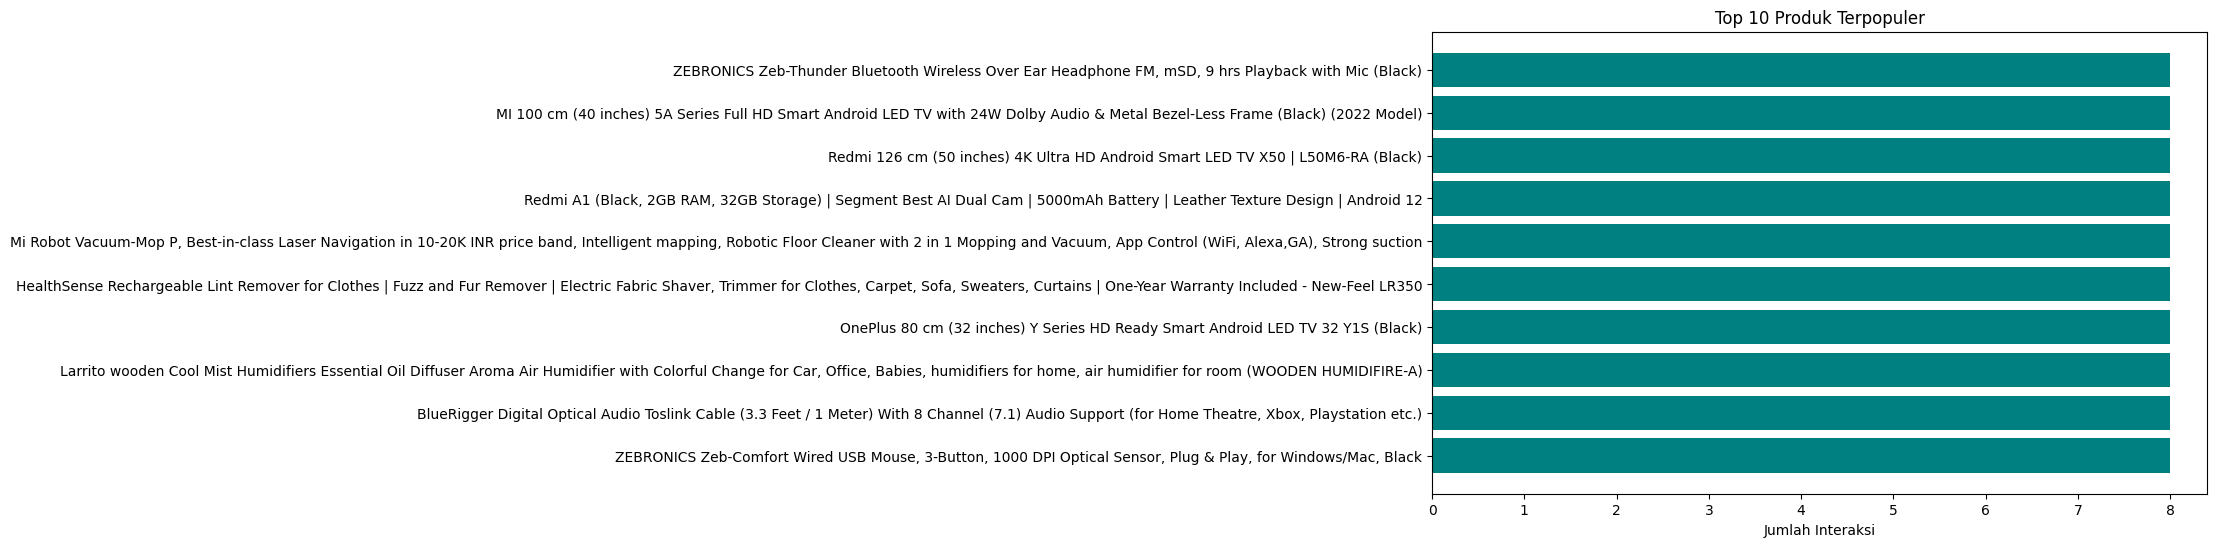

In [25]:
# Top 10 Produk Paling Banyak Dibeli/Dinilai
top_products = df_final.groupBy("product_id", "product_name").count().orderBy(F.desc("count"))

top_products.show(10, truncate=False)

# Visualisasi
top_pd = top_products.limit(10).toPandas()

plt.figure(figsize=(10,6))
plt.barh(top_pd['product_name'], top_pd['count'], color='teal')
plt.xlabel("Jumlah Interaksi")
plt.title("Top 10 Produk Terpopuler")
plt.gca().invert_yaxis()
plt.show()


Creating visualizations...


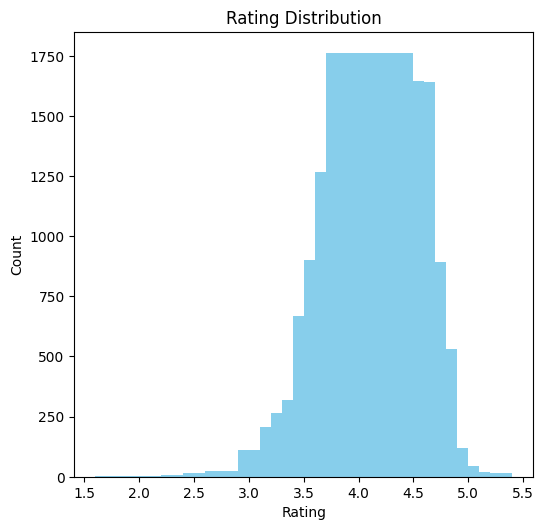

In [26]:
print("Creating visualizations...")

# Rating distribution
rating_dist_pd = df_final.groupBy("rating").count().toPandas()

plt.figure(figsize=(15, 10))

# Plot 1: Rating Distribution
plt.subplot(2, 3, 1)
plt.bar(rating_dist_pd['rating'], rating_dist_pd['count'], color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**MODELING**

In [27]:
(training_data, test_data) = df_final.randomSplit([0.85, 0.15], seed=42)

training_data.cache()
test_data.cache()

print(f"Training data: {training_data.count()} rows")
print(f"Test data: {test_data.count()} rows")

# Cek distribusi rating
print("\nTraining data rating distribution:")
training_data.groupBy("rating").count().orderBy("rating").show(5)

print("\nTest data rating distribution:")
test_data.groupBy("rating").count().orderBy("rating").show(5)


Training data: 8989 rows
Test data: 1608 rows

Training data rating distribution:
+------+-----+
|rating|count|
+------+-----+
|   2.0|    2|
|   2.3|    5|
|   2.6|    7|
|   2.8|   12|
|   2.9|    7|
+------+-----+
only showing top 5 rows


Test data rating distribution:
+------+-----+
|rating|count|
+------+-----+
|   2.6|    1|
|   2.8|    4|
|   2.9|    1|
|   3.0|    6|
|   3.1|    5|
+------+-----+
only showing top 5 rows



In [28]:
from pyspark.sql.functions import count

active_users = df_final.groupBy("user_id").agg(count("product_id").alias("interaction_count")) \
    .filter("interaction_count >= 2")

df_filtered = df_final.join(active_users, on="user_id", how="inner")


In [29]:
active_users.show(5)

+-------+-----------------+
|user_id|interaction_count|
+-------+-----------------+
|    458|                2|
|    908|                2|
|    212|                3|
|    328|                3|
|    227|                3|
+-------+-----------------+
only showing top 5 rows



In [30]:
df_final.count()

10597

In [31]:
df_filtered.count()

2463

**ALS METHOD**

In [32]:
# Collaborative Filtering dengan ALS (Alternating Least Squares)
# Alasan menggunakan ALS: Algoritma matrix factorization yang scalable dan efektif untuk CF

# Configure ALS parameters
als = ALS(
    maxIter=10,              # Maximum iterations
    regParam=0.1,            # Regularization parameter
    rank=100,                 # Number of latent factors
    userCol="user_id",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop", # Handle cold start problem
    nonnegative=True,        # Non-negative matrix factorization
    seed=42
)

print("Training ALS model...")
als_model = als.fit(training_data)
print("ALS model training completed!")

Training ALS model...
ALS model training completed!


In [33]:
# Model Evaluation
# Generate predictions untuk test data
predictions = als_model.transform(test_data)

# Remove NaN predictions (cold start cases)
predictions_clean = predictions.filter(col("prediction").isNotNull())

# Calculate RMSE (Root Mean Square Error)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions_clean)
print(f"Root-mean-square error (RMSE): {rmse:.4f}")

# Calculate MAE (Mean Absolute Error)
evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)

mae = evaluator_mae.evaluate(predictions_clean)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Show sample predictions
print("\nSample Predictions:")
predictions_clean.select("user_id", "product_id", "rating", "prediction").show(5)

Root-mean-square error (RMSE): 1.0321
Mean Absolute Error (MAE): 0.4402

Sample Predictions:
+-------+----------+------+----------+
|user_id|product_id|rating|prediction|
+-------+----------+------+----------+
|    458|       922|   4.0| 3.9473886|
|    284|      1080|   4.0| 3.9445698|
|    296|       835|   4.0| 3.9454224|
|    806|       604|   4.3|  4.249978|
|    882|      1047|   4.1|  4.047913|
+-------+----------+------+----------+
only showing top 5 rows



**Content-Based Similarity METHOD**

In [34]:
# Content-Based Filtering menggunakan TF-IDF
# Menggunakan product features untuk recommendation berdasarkan similarity

print("Building Content-Based Filtering...")

# Prepare product features untuk content-based filtering
products_df = df_final.select(
    "product_id",
    "product_name",
    "category",
    "about_product",
    "category" # Include category column
).distinct()

products_df.show(5)

Building Content-Based Filtering...
+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|        product_name|            category|       about_product|            category|
+----------+--------------------+--------------------+--------------------+--------------------+
|       875|Hindware Atlantic...|Home&Kitchen|Heat...|Stainless Steel T...|Home&Kitchen|Heat...|
|      1001|OnePlus 80 cm (32...|Electronics|HomeT...|Resolution : HD R...|Electronics|HomeT...|
|      1105|Spigen Ultra Hybr...|Electronics|Mobil...|[Compatibility] S...|Electronics|Mobil...|
|       749|boAt Micro USB 55...|Computers&Accesso...|It Ensures High S...|Computers&Accesso...|
|       695|Duracell Chhota P...|Electronics|Gener...|Duracell AA Chota...|Electronics|Gener...|
+----------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [35]:
# Combine text features
products_df = products_df.withColumn(
        "combined_features",
        lower(
            regexp_replace(
                trim(concat_ws(" ",
                    # Weighted features berdasarkan importance
                    repeat(col("product_name"), 3),  # 3x weight untuk nama
                    repeat(col("category"), 2),      # 2x weight untuk kategori
                    col("about_product")
                )),
                "[^a-zA-Z0-9\\s]", " "  # Remove special characters
            )
        )
)

products_df.show(2, truncate=False)
#show only combined_features coloumn
products_df.select("combined_features").show(2, truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
# Tokenization
tokenizer = RegexTokenizer(
        inputCol="combined_features",
        outputCol="words",
        pattern="\\s+",  # Split on whitespace
        minTokenLength=2  # Filter token pendek
    )
products_tokenized = tokenizer.transform(products_df)

#show only combined_features coloumn
products_tokenized.select("words").show(2, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
products_filtered = remover.transform(products_tokenized)


In [38]:
products_filtered.select("filtered_words").show(2, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
# TF-IDF Vectorization
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=20000)
products_tf = hashingTF.transform(products_filtered)

products_tf.cache()

products_tf.select("raw_features").show(2, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|raw_features                                                  

In [40]:
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=3)
idf_model = idf.fit(products_tf)
products_tfidf = idf_model.transform(products_tf)

products_tfidf.cache()

products_tfidf.select("tfidf_features").show(2, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
normalizer = Normalizer(inputCol="tfidf_features", outputCol="normalized_features")
products_tfidf = normalizer.transform(products_tfidf)

In [42]:
products_tfidf.show(2)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|product_id|        product_name|            category|       about_product|            category|   combined_features|               words|      filtered_words|        raw_features|      tfidf_features| normalized_features|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       542|tizum HDMI to VGA...|Electronics|HomeT...|Superior Stabilit...|Electronics|HomeT...|tizum hdmi to vga...|[tizum, hdmi, to,...|[tizum, hdmi, vga...|(20000,[760,834,9...|(20000,[760,834,9...|(20000,[760,834,9...|
|       223|Abode Kitchen Ess...|Home&Kitchen|Kitc...|Each package of m...|Home&Kitchen|Kitc...|abode kitche

**Content-Based Similarity MODELING**

In [43]:
def cosine_similarity_matrix(products_tfidf):

    print("=== COSINE SIMILARITY ===\n")

    features_collected = products_tfidf.select(
        "product_id", "product_name", "category", "normalized_features"
    ).collect()

    similarity_results = []

    for i, row_i in enumerate(features_collected):
        similarities = []

        for j, row_j in enumerate(features_collected):
            if i != j:  # Skip self-comparison
                # Compute cosine similarity
                vec1 = row_i["normalized_features"]
                vec2 = row_j["normalized_features"]

                dot_product = float(vec1.dot(vec2))
                norm1 = float(vec1.norm(2))
                norm2 = float(vec2.norm(2))

                if norm1 > 0 and norm2 > 0:
                    similarity = dot_product / (norm1 * norm2)
                else:
                    similarity = 0.0

                similarities.append({
                    "source_product_id": row_i["product_id"],
                    "source_product_name": row_i["product_name"],
                    "target_product_id": row_j["product_id"],
                    "target_product_name": row_j["product_name"],
                    "target_category": row_j["category"],
                    "similarity": similarity
                })

        similarity_results.extend(similarities)

    return similarity_results

In [44]:
def get_recommendations(product_id, similarity_matrix, num_recommendations=5):
    print("=== GET RECOMMENDATION ===\n")
    # Filter untuk produk target
    recommendations = [
        item for item in similarity_matrix
        if item["source_product_id"] == product_id
    ]

    # Sort by similarity (descending)
    recommendations.sort(key=lambda x: x["similarity"], reverse=True)

    return recommendations[:num_recommendations]

In [45]:
def run_content_filtering(df_fina, limit):
    print("=== CONTENT-BASED FILTERING ===\n")

    # Compute similarity matrix
    similarity_matrix = cosine_similarity_matrix(products_tfidf)
    print("✓ Similarity matrix computed")

    # Test dengan sample products
    sample_products = df_final.select("product_id", "product_name", "category").distinct().limit(limit).collect()

    for product_row in sample_products:
        product_id = product_row["product_id"]
        product_name = product_row["product_name"]
        product_category = product_row["category"]

        print(f"\n=== SIMILAR TO: {product_name} ===")
        print(f"Category: {product_category}")
        print("-" * 60)

        recommendations = get_recommendations(product_id, similarity_matrix, 5)

        if recommendations:
            for i, rec in enumerate(recommendations, 1):
                print(f"{i}. {rec['target_product_name']}")
                print(f"   Category: {rec['target_category']}")
                print(f"   Similarity: {rec['similarity']:.4f}")
                print()
        else:
            print("No recommendations found")

        print("=" * 80)

In [46]:
# Jalankan implementasi
run_content_filtering(df_final, 2)

=== CONTENT-BASED FILTERING ===

=== COSINE SIMILARITY ===

✓ Similarity matrix computed

=== SIMILAR TO: Logitech B100 Wired USB Mouse, 3 yr Warranty, 800 DPI Optical Tracking, Ambidextrous PC/Mac/Laptop - Black ===
Category: Computers&Accessories|Accessories&Peripherals|Keyboards,Mice&InputDevices|Mice
------------------------------------------------------------
=== GET RECOMMENDATION ===

1. Logitech B170 Wireless Mouse, 2.4 GHz with USB Nano Receiver, Optical Tracking, 12-Months Battery Life, Ambidextrous, PC/Mac/Laptop - Black
   Category: Computers&Accessories|Accessories&Peripherals|Keyboards,Mice&InputDevices|Mice
   Similarity: 0.4602

2. Lenovo 300 Wired Plug & Play USB Mouse, High Resolution 1600 DPI Optical Sensor, 3-Button Design with clickable Scroll Wheel, Ambidextrous, Ergonomic Mouse for Comfortable All-Day Grip (GX30M39704)
   Category: Computers&Accessories|Accessories&Peripherals|Keyboards,Mice&InputDevices|Mice
   Similarity: 0.4543

3. Amazon Basics Wireless Mouse

**HYBRID RECOMMENDATION**

In [58]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

def hybrid_recommendations_informative(
    user_id,
    als_model,
    similarity_matrix,
    products_tfidf,
    interactions_df,
    cb_score=0.5,
    cf_score=0.5,
    num_recommendations=5
):
    print(f"\n=== Recommendations for User {user_id} ===")

    # ==== Step 1: User Purchase History ====
    user_history = interactions_df.filter(F.col("user_id") == user_id).select(
        "product_id", "rating"
    ).join(
        products_tfidf.select("product_id", "product_name"),
        on="product_id",
        how="left"
    ).limit(num_recommendations)

    history_count = user_history.count()

    if history_count == 0:
        print("\nUser has no previous purchases or interactions.\n")
    else:
        print("\nUser's Previous Purchases:")
        user_history.select(
            "product_id", "product_name", "rating"
        ).show(truncate=False)

    user_purchased = set(
        row["product_id"] for row in user_history.collect()
    )

    # ==== Step 2: Collaborative Filtering ====
    user_df = spark.createDataFrame([(user_id,)], ["user_id"])

    cf_recommendations = als_model.recommendForUserSubset(
        user_df, num_recommendations * 2
    ).select("recommendations").collect()

    cf_products = []
    if cf_recommendations:
        cf_products = cf_recommendations[0]["recommendations"]

    cf_product_ids = [item["product_id"] for item in cf_products]
    cf_scores = {item["product_id"]: item["rating"] for item in cf_products}

    # ==== Step 3: Content-Based Filtering ====
    cb_scores = {}
    for product_id in cf_product_ids:
        similar_items = [
            item for item in similarity_matrix
            if item["source_product_id"] == product_id
        ]

        for item in similar_items:
            target_id = item["target_product_id"]
            score = item["similarity"]

            cb_scores[target_id] = cb_scores.get(target_id, 0.0) + score

    # ==== Step 4: Combine CF and CB ====
    combined_scores = {}

    for pid, score in cf_scores.items():
        combined_scores[pid] = combined_scores.get(pid, 0) + (score * cf_score)

    for pid, score in cb_scores.items():
        combined_scores[pid] = combined_scores.get(pid, 0) + (score * cb_score)

    # ==== Step 5: Sort & Filter ====
    sorted_recommendations = sorted(
        combined_scores.items(), key=lambda x: x[1], reverse=True
    )

    final_recommendations = [
        (pid, score) for (pid, score) in sorted_recommendations
        if pid not in user_purchased
    ][:num_recommendations]

    # ==== Step 6: Fallback to Popular Items ====
    if not final_recommendations:
        print("\n⚠️  No recommendations found, fallback to Popular Items.\n")

        popular_products = interactions_df.groupBy("product_id").agg(
            F.count("user_id").alias("popularity")
        ).join(
            products_tfidf.select("product_id", "product_name", "category"),
            on="product_id",
            how="left"
        ).orderBy(F.desc("popularity"))

        popular_list = popular_products.filter(
            ~F.col("product_id").isin(list(user_purchased))
        ).limit(num_recommendations).collect()

        final_recommendations = [
            (row["product_id"], row["popularity"]) for row in popular_list
        ]

    # ==== Step 7: Build Output ====
    output_rows = []
    for (pid, score) in final_recommendations:
        product_info = products_tfidf.filter(
            F.col("product_id") == pid
        ).select("product_name", "category").collect()

        if product_info:
            name = product_info[0]["product_name"]
            category = product_info[0]["category"]
        else:
            name = "Unknown Product"
            category = "Unknown"

        output_rows.append((pid, round(score, 6), name, category))

    output_df = spark.createDataFrame(
        output_rows,
        ["product_id", "cf_cb_score_or_popularity", "product_name", "category"]
    )

    print("\nRecommended Products:")
    output_df.show(truncate=False)

    print("\n" + "=" * 80 + "\n")

    return output_df


In [59]:
# Contoh user_id
test_user_id = 1

# Panggil Hybrid Recommendation Informatif
hybrid_recommendations_informative(
    user_id=test_user_id,
    als_model=als_model,
    similarity_matrix=cosine_similarity_matrix(products_tfidf),
    products_tfidf=products_tfidf,
    interactions_df=df_final,  # df_final berisi user_id, product_id, rating
    cb_score=0.3,
    cf_score=0.7,
    num_recommendations=5
)


=== COSINE SIMILARITY ===


=== Recommendations for User 1 ===

User's Previous Purchases:
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|product_id|product_name                                                                                                                                                                                          |rating|
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|1140      |FLiX (Beetel Flow USB to Micro USB PVC Data Sync & 12W(2.4A) Fast Charging Cable,Made in India,480Mbps Data Sync,Solid Cable,1 Meter Long cable for all Andriod & Micro USB Devices (Black)(XCD-FPM01)|4.0   |
|687       |FLiX (Beetel) USB to 

DataFrame[product_id: bigint, cf_cb_score_or_popularity: double, product_name: string, category: string]

In [53]:
# Contoh user_id
test_user_id = 9999

# Panggil Hybrid Recommendation Informatif
hybrid_recommendations_informative(
    user_id=test_user_id,
    als_model=als_model,
    similarity_matrix=cosine_similarity_matrix(products_tfidf),
    products_tfidf=products_tfidf,
    interactions_df=df_final,  # df_final berisi user_id, product_id, rating
    cb_score=0.3,
    cf_score=0.7,
    num_recommendations=5
)


=== COSINE SIMILARITY ===


=== Recommendations for User 9999 ===

User has no previous purchases or interactions.


⚠️  No recommendations found, fallback to Popular Items.


Recommended Products:
+----------+-------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|product_id|cf_cb_score_or_popularity|product_name                                                                                                                                                           |category                                                                        |
+----------+-------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------

DataFrame[product_id: bigint, cf_cb_score_or_popularity: bigint, product_name: string, category: string]

**EVALUATION**

In [49]:
# Model Performance Analysis
# Analisis lebih mendalam tentang performance model

print("=== MODEL PERFORMANCE ANALYSIS ===")

# User dan Item factors analysis
user_factors = als_model.userFactors
item_factors = als_model.itemFactors

print(f"User factors shape: {user_factors.count()} users x {len(user_factors.first()['features'])} factors")
print(f"Item factors shape: {item_factors.count()} items x {len(item_factors.first()['features'])} factors")

# Rating prediction accuracy by rating level
print("\nPrediction Accuracy by Rating Level:")
predictions_clean.groupBy("rating").agg(
    count("*").alias("count"),
    avg("prediction").alias("avg_prediction"),
    avg(abs(col("rating") - col("prediction"))).alias("avg_error")
).orderBy("rating").show()

# Top recommended products overall
print("\nMost Frequently Recommended Products:")
all_recommendations = als_model.recommendForAllUsers(10)
popular_recs = all_recommendations.select(
    explode("recommendations").alias("rec")
).select(
    col("rec.product_id").alias("product_id")
).groupBy("product_id").count().orderBy(desc("count"))

# Join dengan product names
popular_products = popular_recs.join(
    df_final.select("product_id", "product_name").distinct(),
    "product_id"
).select("product_name", "count").limit(10)

popular_products.show(10, truncate=False)

=== MODEL PERFORMANCE ANALYSIS ===
User factors shape: 7794 users x 100 factors
Item factors shape: 1350 items x 100 factors

Prediction Accuracy by Rating Level:
+------+-----+------------------+-------------------+
|rating|count|    avg_prediction|          avg_error|
+------+-----+------------------+-------------------+
|   3.3|    2| 3.238096237182617|0.06190371513366699|
|   3.5|    1|1.7077010869979858| 1.7922989130020142|
|   3.6|    1|1.5285704135894775|  2.071429491043091|
|   3.7|    1|1.8317763805389404| 1.8682236671447754|
|   3.8|   13| 3.560529663012578| 0.2394702801337609|
|   3.9|   24| 3.327181210120519| 0.5728188852469126|
|   4.0|   44|3.7173938669941644| 0.2826061357151378|
|   4.1|   68| 3.715458826983676| 0.3845410767723532|
|   4.2|   74|3.8297619771313025| 0.3702378369666435|
|   4.3|   67|4.0043049783849005| 0.2956952123499628|
|   4.4|   26|3.8309454184312086| 0.5690546769362229|
|   4.5|   12|2.5610053837299347| 1.9389946460723877|
+------+-----+-------------

Creating visualizations...


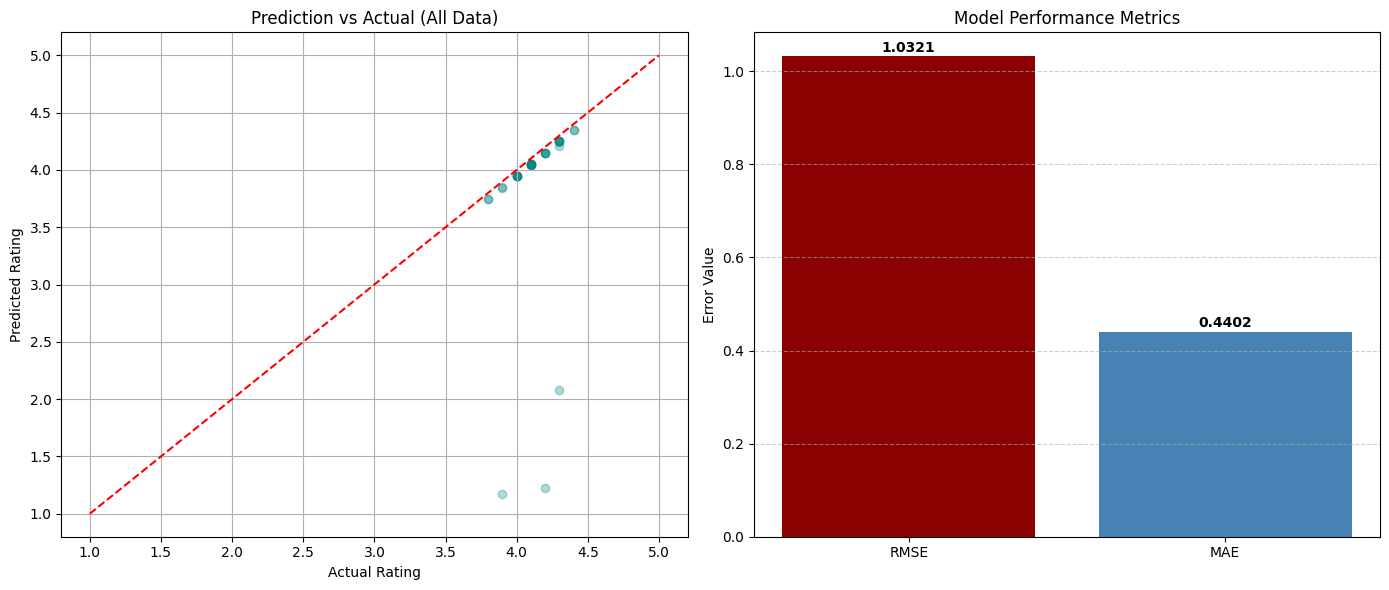

In [62]:
import matplotlib.pyplot as plt

print("Creating visualizations...")

# === Plot 1: Prediction vs Actual (Seluruh Data) ===
pred_all = predictions_clean.select("rating", "prediction").limit(int(0.1 * predictions_clean.count())).toPandas()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(pred_all['rating'], pred_all['prediction'], alpha=0.3, color='teal')
plt.plot([1, 5], [1, 5], 'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Prediction vs Actual (All Data)')
plt.grid(True)

# === Plot 2: Model Performance Metrics ===
plt.subplot(1, 2, 2)
metrics = ['RMSE', 'MAE']
values = [rmse, mae]
plt.bar(metrics, values, color=['darkred', 'steelblue'])
plt.title('Model Performance Metrics')
plt.ylabel('Error Value')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [51]:
# Cleanup dan Stop Spark Session
# Alasan: Important untuk free up resources setelah selesai processing

print("Cleaning up resources...")

# Unpersist cached DataFrames
df_clean.unpersist()
df_interactions.unpersist()
df_final.unpersist()
training_data.unpersist()
test_data.unpersist()
products_tfidf.unpersist()

print("Resources cleaned up successfully")

# Stop Spark session
# spark.stop()
# print("Spark session stopped")

Cleaning up resources...
Resources cleaned up successfully
